In [15]:
%run 00_Dataset.ipynb

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import array
import math
import pandas as pd
#from astropy.cosmology import FlatLambdaCDM
import matplotlib
from matplotlib import gridspec

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [17]:
# create a new FlatLambdaCDM object with arguments giving the Hubble parameter and Omega matter (both at z=0)
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [18]:
if dataset == 'Pantheon':
    skip_header = 6
else :
    skip_header = 0
    
df_SNe = (np.genfromtxt(
    in_filepath,
    skip_header=skip_header, 
    names=True,
    comments='#')
)

df_SNe = pd.DataFrame(df_SNe)

df_SNe = df_SNe.sort_values('zCMB', ascending=False)


In [19]:

if dataset == 'Pantheon':
    df_SNe_binned = pd.read_csv(filt_in_filepath, sep=' ')
    df_SNe_binned['zCMB'] = df_SNe_binned['zcmb']
    df_SNe_binned['zCMBERR'] = df_SNe_binned['dz']
    df_SNe_binned['MU'] = df_SNe_binned['mb'] + 19.36
    df_SNe_binned['MUERR'] = df_SNe_binned['dmb']
    df_SNe_binned = df_SNe_binned.sort_values('zCMB', ascending=False)
    if modelname == 'lstm':
        z = df_SNe['zCMB'].astype(float).to_numpy()
        mu = df_SNe['MU'].astype(float).to_numpy()
        mu_err = df_SNe['MUERR'].astype(float).to_numpy()
    else :
        z = df_SNe_binned['zCMB'].astype(float).to_numpy()
        mu = df_SNe_binned['MU'].astype(float).to_numpy()
        mu_err = df_SNe_binned['MUERR'].astype(float).to_numpy()
else :
    # prepare binned data for union 2.1 sample
    l = np.linspace(0, 2, 200)
    df_SNe_binned = pd.DataFrame(columns=('Name', 'zCMB', 'MU', 'MUERR', 'p'))
    for i in range(0, len(l)-1):
        df_cur = df_SNe[(df_SNe['zCMB'] >= l[i]) & (df_SNe['zCMB'] < l[i+1])]
        sample_size = min(df_cur.shape[0], 3)
        if sample_size == 0: continue
        df_cur = df_cur.sample(sample_size, random_state=100)
        df_SNe_binned = pd.concat([df_SNe_binned, df_cur])
    if modelname == 'lstm':
        z = df_SNe['zCMB'].astype(float).to_numpy()
        mu = df_SNe['MU'].astype(float).to_numpy()
        mu_err = df_SNe['MUERR'].astype(float).to_numpy()
    else:
        z = df_SNe_binned['zCMB'].astype(float).to_numpy()
        mu = df_SNe_binned['MU'].astype(float).to_numpy()
        mu_err = df_SNe_binned['MUERR'].astype(float).to_numpy()   

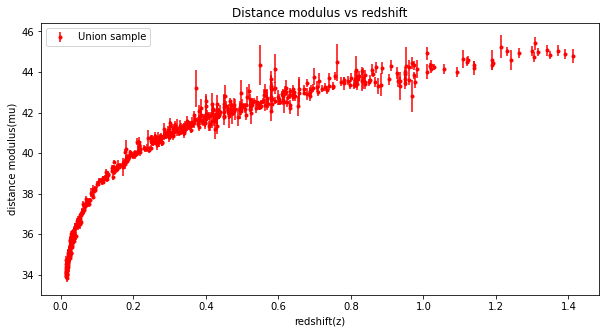

In [20]:
plt.figure(figsize=(10,5))
plt.errorbar(df_SNe['zCMB'], df_SNe['MU'], yerr=df_SNe['MUERR'], fmt='.r',label=dataset+' sample');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
plt.title('Distance modulus vs redshift')
plt.legend()
plt.savefig(os.path.join(out_dir,'01_DistanceModulus_vs_Redshift_'+dataset+'.png'))

plt.show()

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df_train, df_test = train_test_split(df_SNe_binned, test_size=0.2, random_state=123)

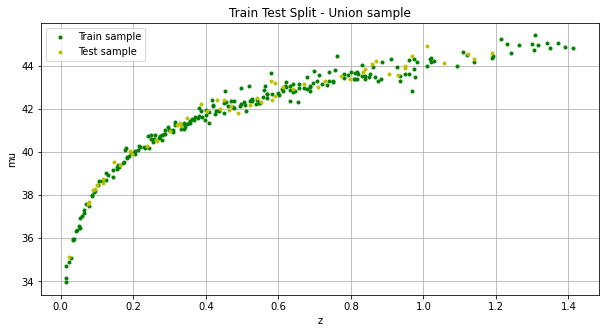

In [23]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,5))

ax1.plot(df_train['zCMB'], df_train['MU'], '.g', label='Train sample')
ax1.plot(df_test['zCMB'], df_test['MU'], '.y', label='Test sample')

ax1.set_ylabel('mu')
ax1.set_xlabel('z')
ax1.set_title('Train Test Split - '+dataset+' sample')
ax1.grid(True)
ax1.legend()

'''
ax2.plot(z_val, mu_val, '.y', label=dataset+' sample')
ax2.set_ylabel('mu')
ax2.set_xlabel('z')
ax2.set_title('Distance modulus vs redshift - Test data')
ax2.grid(True)
ax2.legend()
'''

plt.savefig(os.path.join(out_dir,'02_Train-Test-Split.png'))
plt.show()

In [24]:
# prepare sequential data
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n))

In [25]:
if modelname == 'lstm':
    from sklearn.preprocessing import StandardScaler

    mu_scaler = StandardScaler()
    mu_scaler.fit(mu.reshape(-1,1))
    mu = mu_scaler.transform(mu.reshape(-1,1))

In [26]:
window_size = 4
train_stride = 4

z_strided = strided_app(z, window_size, train_stride)
mu_strided = strided_app(mu, window_size, train_stride)

z_strided = np.append(np.array([z[0], z[0], z[0], z[0]]).reshape(1,-1), z_strided, axis=0)
z_strided = np.append(np.array([z[0], z[0], z[0], z[1]]).reshape(1,-1), z_strided, axis=0)
z_strided = np.append(np.array([z[0], z[0], z[1], z[2]]).reshape(1,-1), z_strided, axis=0)

mu_strided = np.append(np.array([mu[0], mu[0], mu[0], mu[0]]).reshape(1,-1), mu_strided, axis=0)
mu_strided = np.append(np.array([mu[0], mu[0], mu[0], mu[1]]).reshape(1,-1), mu_strided, axis=0)
mu_strided = np.append(np.array([mu[0], mu[0], mu[1], mu[2]]).reshape(1,-1), mu_strided, axis=0)

z_train, z_val, mu_train, mu_val = train_test_split(z_strided, mu_strided, test_size=0.5, random_state=0)

In [27]:
# z_full = np.empty(shape=(0,4))
# mu_full = np.empty(shape=(0,4))
# for i in range(1000):
#     idx = rng.integers(low=0, high=z.shape[0], size=4, dtype=np.int64, endpoint=False)
#     idx = sorted(idx)
#     z_full = np.append(z_full, np.array([z[idx]]), axis=0)
#     mu_full = np.append(mu_full, np.array([mu[idx]]), axis=0)

In [28]:
z_full = np.expand_dims(z_strided, axis=-1)
mu_full = np.expand_dims(mu_strided, axis=-1)
z_train = np.expand_dims(z_train, axis=-1)
#z_test = np.expand_dims(z_test, axis=-1)
z_val = np.expand_dims(z_val, axis=-1)
mu_train = np.expand_dims(mu_train, axis=-1)
#mu_test = np.expand_dims(mu_test, axis=-1)
mu_val = np.expand_dims(mu_val, axis=-1)